<a href="https://colab.research.google.com/github/sharna33/CSE_3210_DSP/blob/main/2003009_CSE3210_LAB_Assignment_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ROLL: 2003009**

## **Perform Convolution on a Music/Audio Signal.**


**Question**: Load a short music/audio signal (e.g., 10-second
audio clip), and perform convolution with a filter. Analyze the effects of the
filtering on the signal and plot the original vs. the filtered signal.

Ø  The filter can be average, median, low-pass, or any other option you choose.

## **Import Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
from IPython.display import Audio, display, Markdown
import requests
from io import BytesIO

def set_plot_style():
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.rcParams.update({
        'figure.figsize': (12, 8),
        'font.size': 12
    })

set_plot_style()

## **Loading the Signal**

In [ ]:
def load_and_process_audio(url, max_duration=10):
    response = requests.get(url)
    audio_stream = BytesIO(response.content)

    sample_rate, data = wavfile.read(audio_stream)

    if data.ndim > 1:
        data = data[:, 0]

    if data.dtype == np.int16:
        data = data.astype(np.float32) / 32767
    elif data.dtype == np.int32:
        data = data.astype(np.float32) / 2147483647

    duration = len(data) / sample_rate

    display_audio_info(sample_rate, duration, data)

    if duration > max_duration:
        data = data[:int(max_duration * sample_rate)]
        display(Markdown(f">Truncated to first **{max_duration} seconds**: {len(data)} samples"))

    return sample_rate, data

def display_audio_info(sample_rate, duration, data):
    info = f"""
---
| Property      | Value                  |
|---------------|------------------------|
| Sample Rate   | {sample_rate} Hz       |
| Duration      | {duration:.2f} seconds |
| Channels      | 1 (Mono)               |
| Sample Count  | {len(data)}            |
| Data Type     | {data.dtype}           |
"""
    display(Markdown(info))

audio_url = "https://github.com/sharna33/CSE_3210_DSP/raw/refs/heads/main/no-signal-7076.wav"

sr, audio = load_and_process_audio(audio_url)


---
| Property      | Value                  |
|---------------|------------------------|
| Sample Rate   | 22050 Hz       |
| Duration      | 9.87 seconds |
| Channels      | 1 (Mono)               |
| Sample Count  | 217728            |
| Data Type     | float32           |


## **Original Signal**

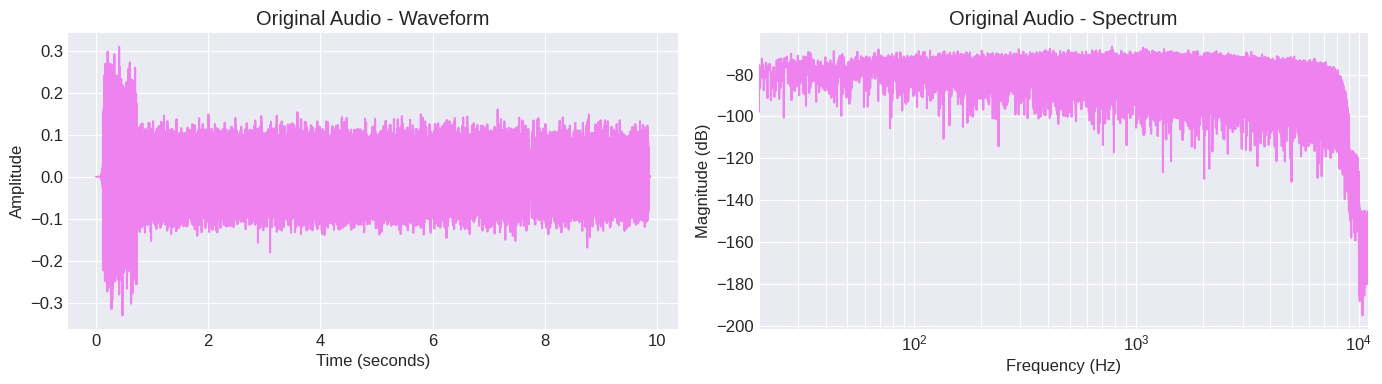

In [ ]:
def plot_waveform(signal_data, sr, title="Waveform", color='violet', alpha=1.0):
    time_axis = np.arange(len(signal_data)) / sr
    plt.plot(time_axis, signal_data, color=color, alpha=alpha)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.grid(True)

def plot_spectrum(signal_data, sr, title="Frequency Spectrum", color='violet', alpha=1.0):
    n = len(signal_data)
    freq_axis = np.fft.rfftfreq(n, d=1/sr)
    magnitude = np.abs(np.fft.rfft(signal_data)) / n
    magnitude_db = 20 * np.log10(magnitude + 1e-10)

    plt.semilogx(freq_axis, magnitude_db, color=color, alpha=alpha)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.title(title)
    plt.grid(True, which="both")
    plt.xlim(20, sr / 2)

def display_audio_analysis(signal_data, sr, name="Audio"):
    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plot_waveform(signal_data, sr, title=f"{name} - Waveform")

    plt.subplot(1, 2, 2)
    plot_spectrum(signal_data, sr, title=f"{name} - Spectrum")

    plt.tight_layout()
    plt.show()

display_audio_analysis(audio, sr, name="Original Audio")

## **Building Bandpass Signal**

In [ ]:
def build_bandpass_filter(low_freq, high_freq, sr, order=5):
    nyquist = sr / 2.0
    normalized_low = low_freq / nyquist
    normalized_high = high_freq / nyquist

    b, a = signal.butter(order, [normalized_low, normalized_high], btype='band')
    return b, a

In [ ]:
b_bandpass, a_bandpass = build_bandpass_filter(500, 3000, sr=sr)
filtered_signal = signal.lfilter(b_bandpass, a_bandpass, audio)

## **Listening Original & Filtered Audio**

In [ ]:
def play_audio(signal_data, sr, label="Audio", normalize=True):
    if normalize:
        max_val = np.max(np.abs(signal_data))
        if max_val > 0:
            signal_data = signal_data / max_val  # Normalize to [-1, 1]

    display(Markdown(f"**{label}**"))
    display(Audio(signal_data, rate=sr))

play_audio(audio, sr, label="Original Audio")
play_audio(filtered_signal, sr, label="Filtered Audio (500–3000 Hz Band-Pass)")

**Original Audio**

**Filtered Audio (500–3000 Hz Band-Pass)**

## **Zoomed View of Signal and Its Frequency Content**

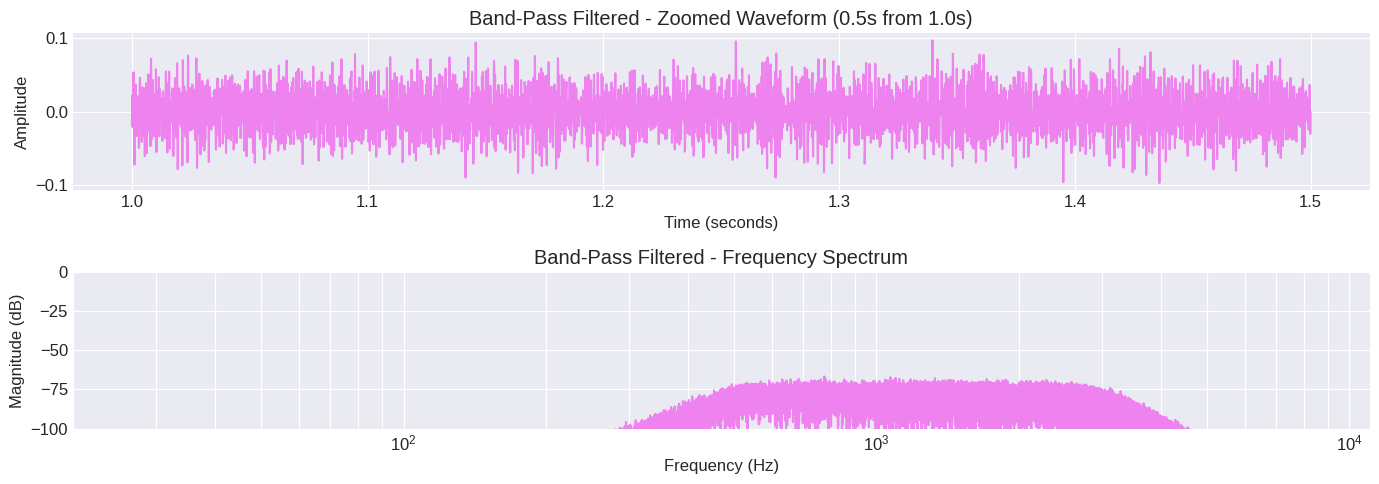

In [ ]:
def plot_filtered_audio_analysis(signal_data, sr, start_time=1.0, duration=0.5, label='Filtered Signal', color='violet'):
    start_idx = int(start_time * sr)
    end_idx = int((start_time + duration) * sr)
    time_axis = np.arange(start_idx, end_idx) / sr
    segment = signal_data[start_idx:end_idx]

    plt.figure(figsize=(14, 5))

    plt.subplot(2, 1, 1)
    plt.plot(time_axis, segment, color=color, label=label)
    plt.title(f'{label} - Zoomed Waveform ({duration}s from {start_time}s)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plot_spectrum(signal_data, sr, title=f'{label} - Frequency Spectrum', color=color)
    plt.ylim(-100, 0)

    plt.tight_layout()
    plt.show()

plot_filtered_audio_analysis(filtered_signal, sr, start_time=1.0, duration=0.5, label='Band-Pass Filtered')

## **Comparing Original & Filtered Signal**

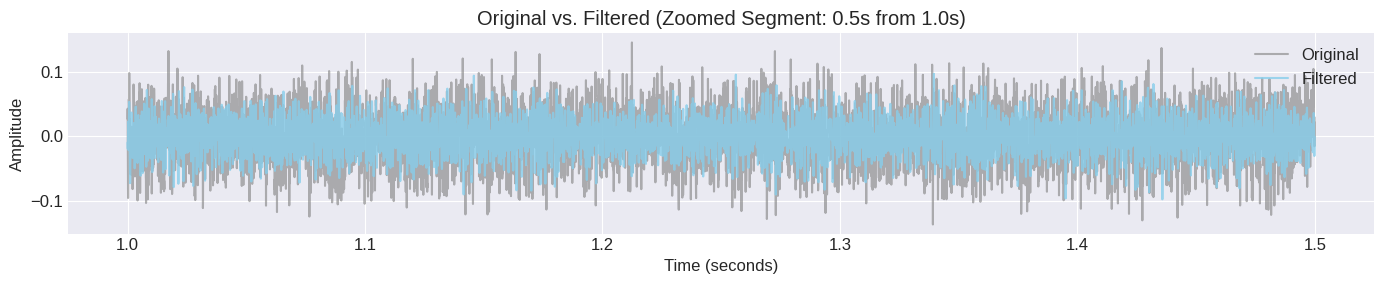

In [ ]:
def compare_waveforms(original_signal, filtered_signal, sr, start_sec=1.0, duration_sec=0.5, labels=('Original', 'Filtered'), colors=('grey', 'skyblue')):
    start_idx = int(start_sec * sr)
    end_idx = int((start_sec + duration_sec) * sr)
    time_axis = np.arange(start_idx, end_idx) / sr

    segment_original = original_signal[start_idx:end_idx]
    segment_filtered = filtered_signal[start_idx:end_idx]

    plt.figure(figsize=(14, 3))
    plt.plot(time_axis, segment_original, alpha=0.6, label=labels[0], color=colors[0])
    plt.plot(time_axis, segment_filtered, alpha=0.8, label=labels[1], color=colors[1])
    plt.title(f'{labels[0]} vs. {labels[1]} (Zoomed Segment: {duration_sec}s from {start_sec}s)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

compare_waveforms(audio, filtered_signal, sr, start_sec=1.0, duration_sec=0.5)